# Setup

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#pytorch libraries

#other libraries
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

cuda


# Loading the data into a dataset class

In [2]:
pokemon_info = pd.read_csv('../datasets/processed/pokemon.csv')
pokemon_info.head()

,name,image,type1,type2,dex
0,bulbasaur,../datasets/raw/renders_2d/images/1.png,grass,poison,1
1,ivysaur,../datasets/raw/renders_2d/images/2.png,grass,poison,2
2,venusaur,../datasets/raw/renders_2d/images/3.png,grass,poison,3
3,charmander,../datasets/raw/renders_2d/images/4.png,fire,NaN,4
4,charmeleon,../datasets/raw/renders_2d/images/5.png,fire,NaN,5


## OneHot encoding the Types

In [3]:
def onehot(df):
    """Use df to:
     - Create unique list of pokemon types
     - Loop through Type1 and Type2 column
     - Create one-hot encoding for each type
     - Return one-hot encoding for each type as numpy array"""

    all_types = df['type1'].to_list() + df['type2'].to_list()
    uniques = list(set(all_types))
    uniques = [ x for x in uniques if isinstance(x, str) ] # remove nan by keeping only strings
    
    onehot = np.zeros((len(df), len(uniques)))
    for i, row in df.iterrows():
        type1 = row['type1']
        type2 = row['type2']

        # only work with non nan
        if isinstance(type1, str):
            onehot[i, uniques.index(type1)] = 1
        if isinstance(type2, str):
            onehot[i, uniques.index(type2)] = 1

    return onehot, uniques

In [4]:
onehot_enc, uniques = onehot(pokemon_info)
print(onehot_enc.shape)
print(uniques)

(704, 18)
['fairy', 'steel', 'bug', 'fighting', 'ghost', 'water', 'dark', 'rock', 'normal', 'ground', 'flying', 'ice', 'poison', 'dragon', 'grass', 'psychic', 'electric', 'fire']


Helper function for showing a pokemon and its name and types

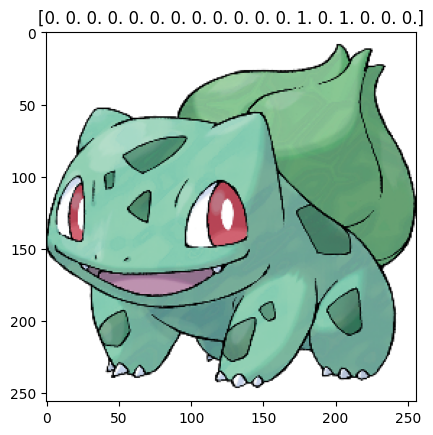

In [5]:
def show_pokemon(image, types):
    """Show image with name, types and evolution of pokemon"""
    plt.imshow(image)
    plt.title(str(types))
    plt.pause(0.001)  # pause a bit so that plots are updated

show_pokemon(Image.open(pokemon_info['image'][0]),
               onehot_enc[0])

In [6]:
class PokemonDataset(Dataset):
    """Pokemon dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pokemon_info = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pokemon_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_name = os.path.join(self.root_dir, str(idx+1) + '.png')
        img_name = self.pokemon_info['image'][idx]
        image = Image.open(img_name).convert('RGB')
        # image = np.asarray(image)

        # onehot encode the types
        # sample = {'image': image, 'types': onehot_enc[idx]}

        if self.transform:
            image = self.transform(image)

        return image, onehot_enc[idx]

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

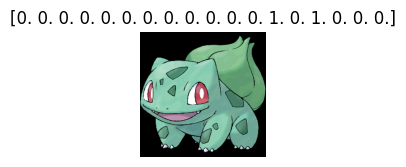

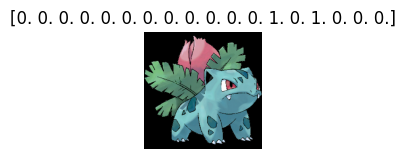

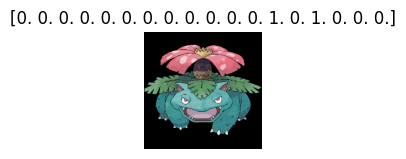

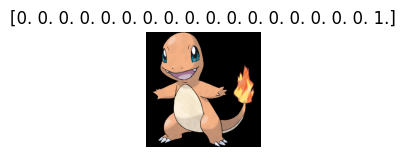

In [7]:
pokemon_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                 root_dir='../datasets/raw/renders_2d/images/')

fig = plt.figure()

for i, (image, types) in enumerate(pokemon_dataset):

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pokemon(image, types)

    if i == 3:
        plt.show()
        break

# Transform to Tensors

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [9]:
transformed_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                     root_dir='../datasets/raw/renders_2d/images/',
                                     transform=transform)

for i, (image, types) in enumerate(transformed_dataset):
    print(i, image.size())
    if i == 0:
        break

0 torch.Size([3, 256, 256])


# Save dataloader and encoding mappings

In [10]:
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [0.9, 0.1])

In [13]:
batch_size = 16

g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=batch_size,
                        shuffle=False, num_workers=2)


In [14]:
for (image, types) in train_loader:
    print(image.size())
    print(image.size())
    break

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


In [60]:
class AutoEncoder(nn.Module):
    def __init__(self, image_size, latent_dim=64, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        self.shape = None
        
        flatten_size = 128 * (image_size // 8) * (image_size // 8)
        
        self.latent = nn.Linear(flatten_size, latent_dim)
        
        self.decode_input = nn.Linear(latent_dim, flatten_size)
        
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    # def label_injection(self, x, y):
    #     y = y.view(-1, self.num_classes, 1, 1).float()
    #     labels = self.label_projection(y)
    #     return x + labels
        
    def forward(self, x,y):
        encoded = self.encoder(x)
        self.shape = encoded.shape[1:] #save for later
        encoded = encoded.view(encoded.size(0), -1)
        latent = self.latent(encoded)
        inverse_latent = self.decode_input(latent)
        inverse_latent = inverse_latent.view(encoded.size(0), *self.shape)
        decoded = self.decoder(inverse_latent)
        return decoded
    

In [61]:
auto_encoder = AutoEncoder(image_size=256, num_classes=len(uniques))

auto_encoder.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(auto_encoder.parameters(), lr=1e-5)

In [62]:
auto_encoder

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (latent): Linear(in_features=131072, out_features=64, bias=True)
  (decode_input): Linear(in_features=64, out_features=131072, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [63]:
#training process

epochs = 500
outputs = []

loss_list = []
 

for epoch in range(1,epochs+1):
    loss_avg = 0
    for i, data in enumerate(train_loader, start=1):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(images.shape)
        # print(labels.shape)
        
        recon = auto_encoder(images, y=labels)
        # print(recon.shape)
        # print(images.shape)
        
        loss = loss_fn(recon, images)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
    loss_avg = loss_avg / len(train_loader)
    loss_list.append(loss_avg)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss_avg:.4f}')  
    outputs.append((epoch, images, recon))

Epoch [10/500], Loss: 0.0775
Epoch [20/500], Loss: 0.0667
Epoch [30/500], Loss: 0.0479
Epoch [40/500], Loss: 0.0394
Epoch [50/500], Loss: 0.0350
Epoch [60/500], Loss: 0.0322
Epoch [70/500], Loss: 0.0303
Epoch [80/500], Loss: 0.0288
Epoch [90/500], Loss: 0.0277
Epoch [100/500], Loss: 0.0269
Epoch [110/500], Loss: 0.0260
Epoch [120/500], Loss: 0.0254
Epoch [130/500], Loss: 0.0247
Epoch [140/500], Loss: 0.0243


KeyboardInterrupt: 

torch.Size([4, 3, 256, 256])


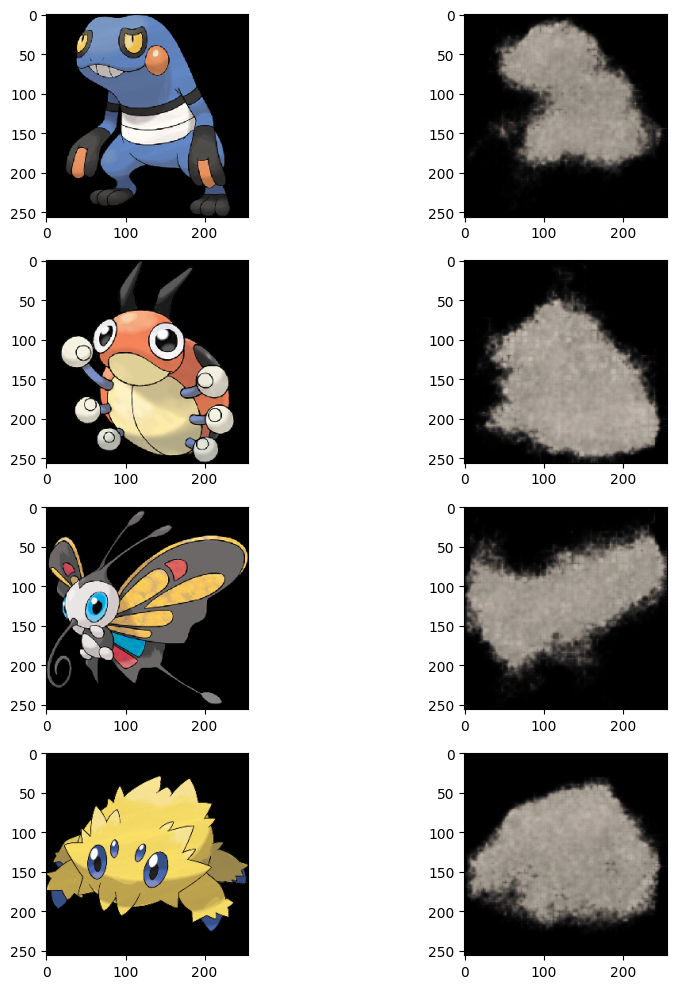

In [59]:


for i, data in enumerate(val_loader):
    (images, labels) = data
    # fire_type = torch.tensor(onehot_enc[3])
    # test_labels = fire_type.repeat(8, 1)
    # test_labels.to(device)
    images, labels = images.to(device), labels.to(device)
    print(images.shape)
    # images_reshaped = images.reshape(-1, 32*32)
    recon = auto_encoder(images, labels).to(device)
    break
fig, ax = plt.subplots(4, 2, figsize=(10,10))
for i in range(4):
    ax[i,0].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[i,1].imshow(recon[i].permute(1, 2, 0).cpu().detach().numpy())
plt.tight_layout()

In [69]:
torch.save(auto_encoder, '../models/auto_encoder.pt')